In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians
import contextily as ctx
from sklearn.cluster import DBSCAN
import datetime
import folium
import matplotlib.lines as mlines

In [8]:
#---------------------------------#
# DATA CLEANING & PREPROCESSING
#---------------------------------#

traffic_metadata = pd.read_csv("traffic_metadata.csv") # storing metadata

dfs = [] # empty list for assigning merged dataset

dataset_directory = "./traffic_dataset" # directory endpoint

for filename in os.listdir(dataset_directory): # looping through all the traffic_dataset and merge to one list
    df = pd.read_csv(os.path.join(dataset_directory, filename))
    df = df.merge(traffic_metadata[['REPORT_ID', 'POINT_1_LAT', 'POINT_1_LNG', 'POINT_2_LAT', 'POINT_2_LNG']], on='REPORT_ID', how='left')
    dfs.append(df) 

final_df = pd.concat(dfs, ignore_index=True) # concatenate all the dataframes to final dataframe

In [9]:
final_df_clean = final_df[['TIMESTAMP', 'vehicleCount', '_id', 'REPORT_ID', 'POINT_1_LAT', 'POINT_1_LNG', 'POINT_2_LAT', 'POINT_2_LNG']] # removing - status, avgMeasuredTime, avgSpeed, extID, medianMeasuredTime
# here we want stationary vehicle data, so we are considering avgSpeed = 0, hence it will be in that particular location in that particular time
final_df_clean = final_df_clean.dropna() # dropping all the rows which has null values in any one of the cell
duplicates = final_df_clean.duplicated(subset=['_id'], keep=False) # check for duplicate rows based on the '_id' column
final_df_clean_no_duplicates = final_df_clean[~duplicates] # create a new DataFrame containing only the non-duplicate rows
num_duplicates = len(final_df_clean) - len(final_df_clean_no_duplicates)
final_df_clean = final_df_clean[~duplicates] # delete duplicates and assign to dataframe
# #-----------------------------------------------------------------------
# print(f"Number of duplicates found in the dataframe: {num_duplicates}")
# #-----------------------------------------------------------------------

final_df_clean = final_df_clean[final_df_clean['vehicleCount'] <= 100] # remove records with traffic count values greater than 100, 
final_df_clean['TIMESTAMP'] = pd.to_datetime(final_df_clean['TIMESTAMP']) # convert 'TIMESTAMP' column to datetime format
# calculate the number of consecutive missing hours per day
missing_hours = final_df_clean.groupby(['REPORT_ID', final_df_clean['TIMESTAMP'].dt.date])['TIMESTAMP'].diff().dt.total_seconds() / 3600
final_df_clean['missing_hours'] = missing_hours.fillna(0).astype(int)

# mark days as invalid if they have more than 4 consecutive missing hours
invalid_days = final_df_clean.groupby(['REPORT_ID', final_df_clean['TIMESTAMP'].dt.date])['missing_hours'].transform(lambda x: (x >= 4).any())
final_df_clean['invalid_day'] = invalid_days
final_df_clean = final_df_clean[~final_df_clean['invalid_day']] # filter out invalid days
final_df_clean.reset_index(drop=True, inplace=True) # reset the index

In [10]:
#---------------------------------#
# FUNCTION FOR HAVERSINE DISTANCE
#---------------------------------#

# Haversine distance calculation function
def haversine_distance(point1, point2):
    lat1, lon1 = point1
    lat2, lon2 = point2

    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = 6371 * c  # Radius of the Earth in kilometers

    return distance

In [11]:
#---------------------------------#
# CLUSTERING LOCATION - DBSCAN
#---------------------------------#

# Define eps and min_samples
eps = 0.5  # Maximum distance between two points in kilometers
min_samples = 2

# Create a copy of the original DataFrame
new_df = final_df_clean.copy()

# Remove duplicates based on the specified columns
new_df = new_df.drop_duplicates(subset=['POINT_1_LAT', 'POINT_1_LNG','REPORT_ID'])
# Instance of DBSCAN and fit the model to the new_df using Haversine distance
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=haversine_distance).fit(new_df[['POINT_1_LAT', 'POINT_1_LNG']])
n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

plt.figure(figsize=(6, 6))
scatter = plt.scatter(new_df['POINT_1_LAT'], new_df['POINT_1_LNG'], c=dbscan.labels_, s=10, cmap='viridis')
# Scatter plot with DBSCAN clustering
#plt.scatter(new_df['POINT_1_LAT'], new_df['POINT_1_LNG'], c=dbscan.labels_, s=10, cmap='viridis')

# Defining labels and title of the plot
plt.title(f'DBSCAN clustering with eps={eps} km, min_samples={min_samples}')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend( title=f'Clusters: {n_clusters}', loc='lower right')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [12]:
#---------------------------------#
# DATA FRAME FOR CLUSTERS
#---------------------------------#

# Extract cluster labels
cluster_labels = dbscan.labels_

# Create a DataFrame with cluster labels and coordinates
clustered_df = pd.DataFrame({'Cluster': cluster_labels, 'Latitude': new_df['POINT_1_LAT'], 'Longitude': new_df['POINT_1_LNG']})

# Group points by cluster label
clusters = clustered_df.groupby('Cluster')

# Create a new DataFrame to store the cluster ID and report ID
cluster_report_df = pd.DataFrame({'Cluster_ID': cluster_labels, 'REPORT_ID': new_df['REPORT_ID']})

# Assuming you want to remove rows with Cluster_ID equal to -1
cluster_report_df = cluster_report_df[cluster_report_df['Cluster_ID'] != -1]

# Group the data based on the cluster ID and collect the report IDs for each cluster
clustered_reports = cluster_report_df.groupby('Cluster_ID')['REPORT_ID'].apply(list).reset_index()

In [13]:
#---------------------------------#
# DATA EXPLORATION - ONE WEEK
#---------------------------------#

In [14]:
#---------------------------------#
# FUNCTION FOR PLOTTING TIME SERIES
#---------------------------------#

def plot_timeseries(selected_day_df, desired_date):
    # Create a dictionary to store the data
    report_data_dict = {'REPORT_ID': [], 'Hour': [], 'Vehicle_Count': []}

    # the maximum length of time series, will be 24hrs
    max_length = 24

    report_ids_df = selected_day_df['REPORT_ID'].unique() # create a separate time series line plot for each REPORT_ID

    plt.figure(figsize=(12, 6))

    #  is a Series that results from grouping the report_data DataFrame by the hour of the 'TIMESTAMP' column and then summing the 'vehicleCount' column for each hour.
    for report_id in report_ids_df:
        report_ids = selected_day_df[selected_day_df['REPORT_ID'] == report_id].copy()
        hourly_counts = report_ids.groupby(report_ids['TIMESTAMP'].dt.hour)['vehicleCount'].sum()
        for hour, count in zip(hourly_counts.index, hourly_counts.values):
            report_data_dict['REPORT_ID'].append(report_id)
            report_data_dict['Hour'].append(hour)
            report_data_dict['Vehicle_Count'].append(count)
        plt.plot(hourly_counts.index, hourly_counts.values, label=f'REPORT_ID {report_id}')

    # Create a DataFrame from the dictionary
    report_data_df = pd.DataFrame(report_data_dict)

    plt.xlabel('Hour of the Day')
    plt.ylabel('Total Vehicle Count')
    plt.title(f'Hourly Vehicle Count Time Series Visualization (24Hrs) - {desired_date}')
    plt.xticks(range(max_length)) # ensure x-axis ticks represent each hour
plt.show()

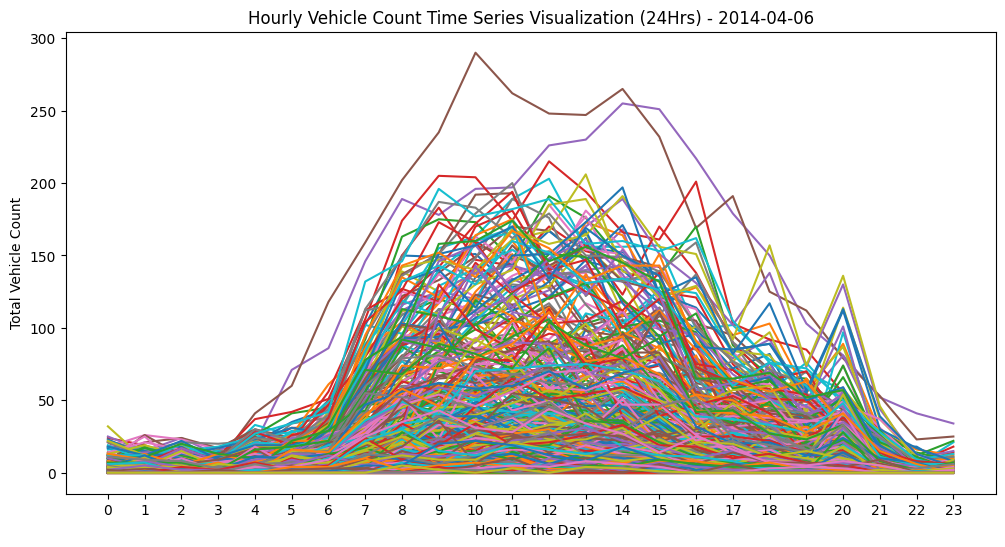

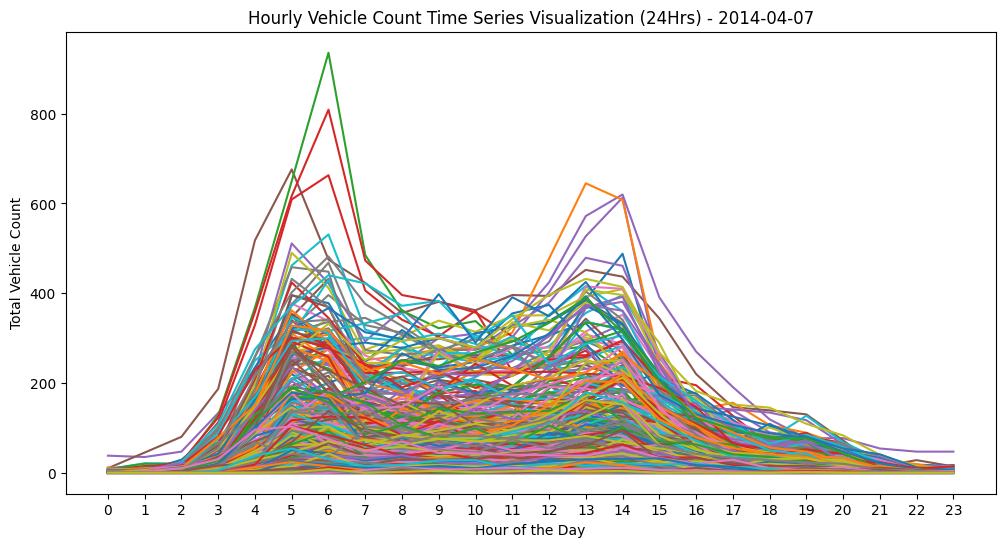

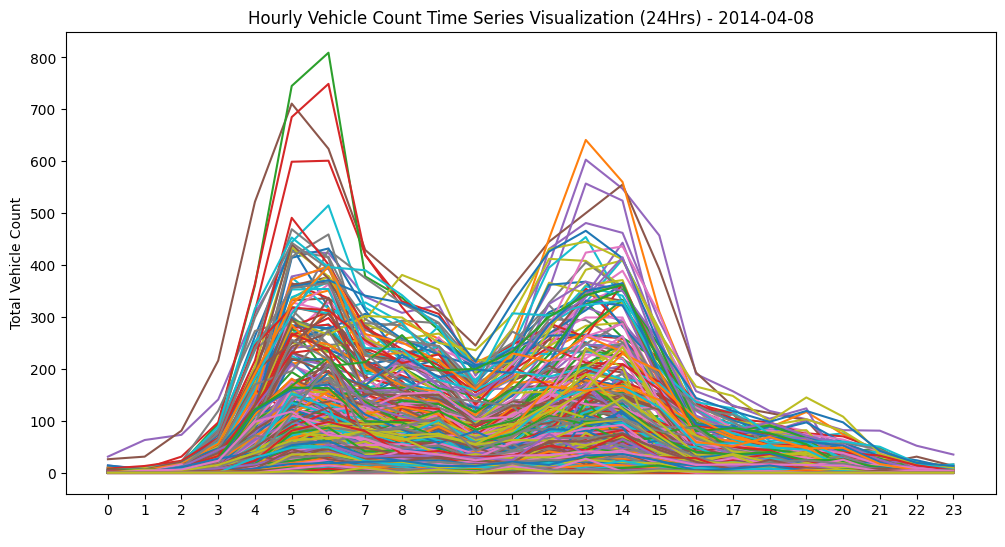

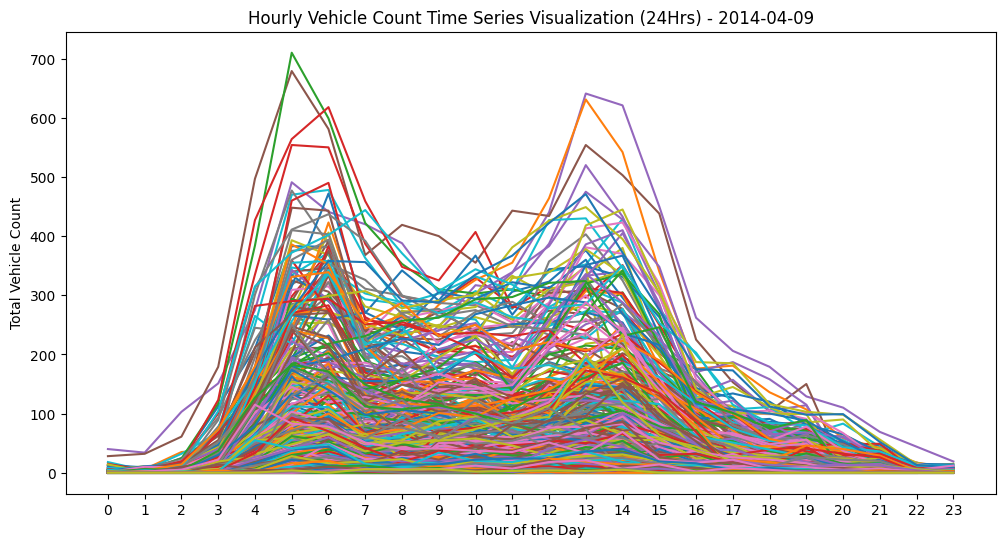

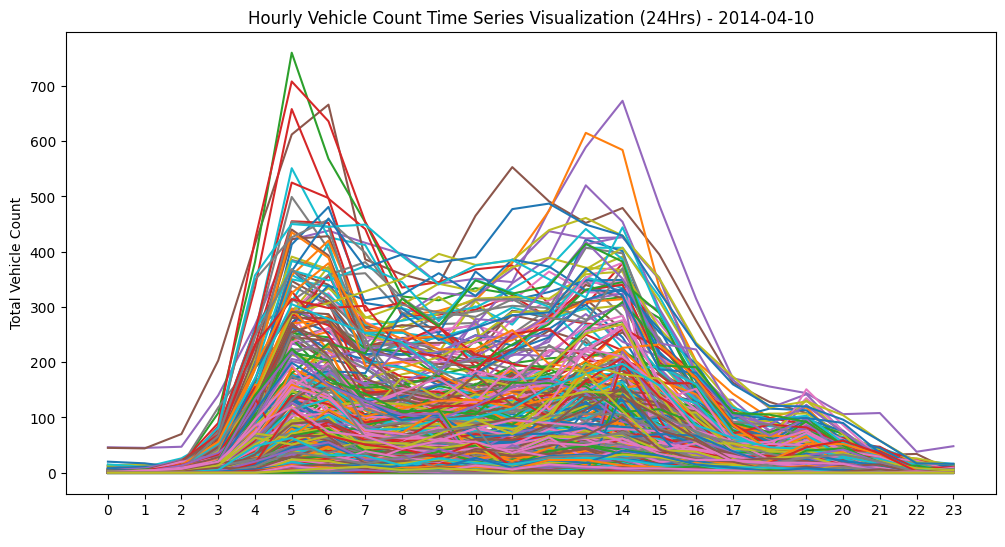

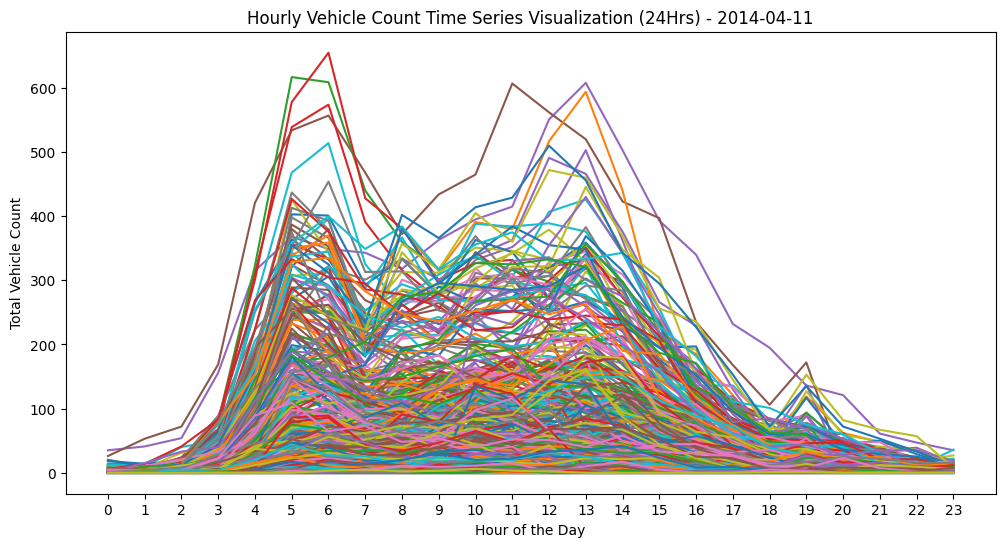

In [15]:
#---------------------------------#
# PLOTTING TIME SERIES
#---------------------------------#

desired_dates = ['2014-04-06', '2014-04-07', '2014-04-08', '2014-04-09', '2014-04-10', '2014-04-11', '2014-04-12'] # replace with the date you want
selected_day_df = []

final_df_clean.loc[:, 'TIMESTAMP'] = pd.to_datetime(final_df_clean['TIMESTAMP']) # convert the 'TIMESTAMP' column to datetime format

for desired_date in desired_dates:
    selected_day_df = final_df_clean[final_df_clean['TIMESTAMP'].dt.date == pd.to_datetime(desired_date).date()] # filter the DataFrame for the desired date
    plot_timeseries(selected_day_df, desired_date)

In [16]:
#---------------------------------#
# FUNCTION FOR CREATING DATA FRAME - DIFFERENT DAYS
#---------------------------------#

def different_days(final_df_clean, desired_date1):
    # Create a dictionary to store the data
    desired_date = desired_date1
    
    final_df_clean.loc[:, 'TIMESTAMP'] = pd.to_datetime(final_df_clean['TIMESTAMP'])
    selected_day_df = final_df_clean[final_df_clean['TIMESTAMP'].dt.date == pd.to_datetime(desired_date).date()]
    
    report_data_dict = {'REPORT_ID': [], 'Hour': [], 'Vehicle_Count': [], 'Date': []}
    
    max_length = 24
    
    report_ids_df = selected_day_df['REPORT_ID'].unique()
    
    for report_id in report_ids_df:
        report_ids = selected_day_df[selected_day_df['REPORT_ID'] == report_id].copy()
        hourly_counts = report_ids.groupby(report_ids['TIMESTAMP'].dt.hour)['vehicleCount'].sum()
        for hour, count in zip(hourly_counts.index, hourly_counts.values):
            report_data_dict['Date'].append(desired_date)
            report_data_dict['REPORT_ID'].append(report_id)
            report_data_dict['Hour'].append(hour)
            report_data_dict['Vehicle_Count'].append(count)
    
    # Create a DataFrame from the dictionary
    report_data_df = pd.DataFrame(report_data_dict)
    return report_data_df
   
# Define the start and end date of the week with the most traffic
start_date = datetime.date(2014, 4, 6) # replace with the date you want
end_date = datetime.date(2014, 4, 12) # replace with the date you want
# Initialize an empty list to store DataFrames
all_report_data_df = pd.DataFrame()
# Iterate through the dates within the week
current_date = start_date
while current_date <= end_date:
    desired_date = current_date.strftime('%Y-%m-%d')
    output = different_days(final_df_clean, desired_date)
    #print(output.count())
    current_date += datetime.timedelta(days=1)
    all_report_data_df = pd.concat([all_report_data_df, output])

In [17]:
#---------------------------------#
# DATA FRAME FOR ALL DAY DATA - SAMPLE THRESHOLD APPLIED FOR TESSTING
#---------------------------------#

# Initialize a list to store DataFrames for each cluster
result_dfs = []
unique_dates = all_report_data_df['Date'].unique()

# Iterate through each cluster group
for date in unique_dates:
    all_report_data_df_date = all_report_data_df[all_report_data_df['Date'] == date].copy()
    # Iterate through each hour
    for cluster_id, report_ids in zip(clustered_reports['Cluster_ID'], clustered_reports['REPORT_ID']):
        cluster_hours = []
        cluster_vehicle_counts = []
        cluster_date = []
        cluster_num = []
        cluster_length=[]
    
         # Calculate the threshold based on the number of REPORT_IDs in the cluster
        length = len(report_ids)
        threshold = length * 50  # Multiply the fixed threshold (50) by the number of REPORT_IDs
        
        # Define the start and end date of the week with the most traffic
        # Iterate through the REPORT_IDs and sum the vehicle counts for the current hour
        for hour in range(24):
            total_count = 0
            total_count_density = 0
            for report_id in report_ids:
                count = all_report_data_df_date[(all_report_data_df_date["REPORT_ID"] == report_id) & (all_report_data_df_date["Hour"] == hour)& (all_report_data_df_date["Date"] == date)]["Vehicle_Count"].sum()
                total_count += count
            cluster_hours.append(hour)
            cluster_vehicle_counts.append(total_count)
            cluster_date.append(date)
            cluster_num.append(cluster_id)
            cluster_length.append(length)
        # Create a DataFrame for the current cluster
        cluster_df = pd.DataFrame({"Date": cluster_date, "Cluster_ID": cluster_num, "Hour": cluster_hours, "Total_Vehicle_Count": cluster_vehicle_counts, "Threshold": threshold, "Length": cluster_length})
        # Append the current cluster's data to the list of result DataFrames
        result_dfs.append(cluster_df)

# Concatenate all cluster DataFrames into a single result DataFrame
result_df = pd.concat(result_dfs, ignore_index=True)

# Add a new column 'Congested' based on the threshold
result_df['Congested'] = result_df['Total_Vehicle_Count'] > result_df['Threshold']
# Print the updated result DataFrame
print(result_df.head())

         Date  Cluster_ID  Hour  Total_Vehicle_Count  Threshold  Length  \
0  2014-04-06           0     0                    6        100       2   
1  2014-04-06           0     1                    2        100       2   
2  2014-04-06           0     2                    0        100       2   
3  2014-04-06           0     3                    4        100       2   
4  2014-04-06           0     4                   17        100       2   

   Congested  
0      False  
1      False  
2      False  
3      False  
4      False  


In [18]:
#---------------------------------#
# FINDING PERCENTIES USING QUANTILE METHOD
#---------------------------------#

# Calculate the 25th, 50th (median), and 75th percentiles for the entire dataset
quantiles_on_result_df = result_df['Total_Vehicle_Count'].quantile([0.50, 0.75, 1])
print(quantiles_on_result_df)

# Assuming you have the quantile values and have created the 'result_df' DataFrame
quantiles1 = 82.0
quantiles2 = 246.0
quantiles3 = 3551.0

# Define a custom function to categorize the 'Congested' values
def categorize_congested(row):
    if (row['Total_Vehicle_Count'] <= quantiles1 * row['Length']):
        return '1'
    elif (row['Total_Vehicle_Count'] > quantiles1 * row['Length']) and (row['Total_Vehicle_Count'] <= quantiles2 * row['Length']):
        return '2'
    elif (row['Total_Vehicle_Count'] > quantiles2 * row['Length']) and (row['Total_Vehicle_Count'] <= quantiles3 * row['Length']):
        return '3'

# Apply the custom function to create the 'Congested' column
result_df['Congested_label'] = result_df.apply(categorize_congested, axis=1)

# Print the updated DataFrame
print(result_df.head())

0.50      82.0
0.75     246.0
1.00    3551.0
Name: Total_Vehicle_Count, dtype: float64
         Date  Cluster_ID  Hour  Total_Vehicle_Count  Threshold  Length  \
0  2014-04-06           0     0                    6        100       2   
1  2014-04-06           0     1                    2        100       2   
2  2014-04-06           0     2                    0        100       2   
3  2014-04-06           0     3                    4        100       2   
4  2014-04-06           0     4                   17        100       2   

   Congested Congested_label  
0      False               1  
1      False               1  
2      False               1  
3      False               1  
4      False               1  


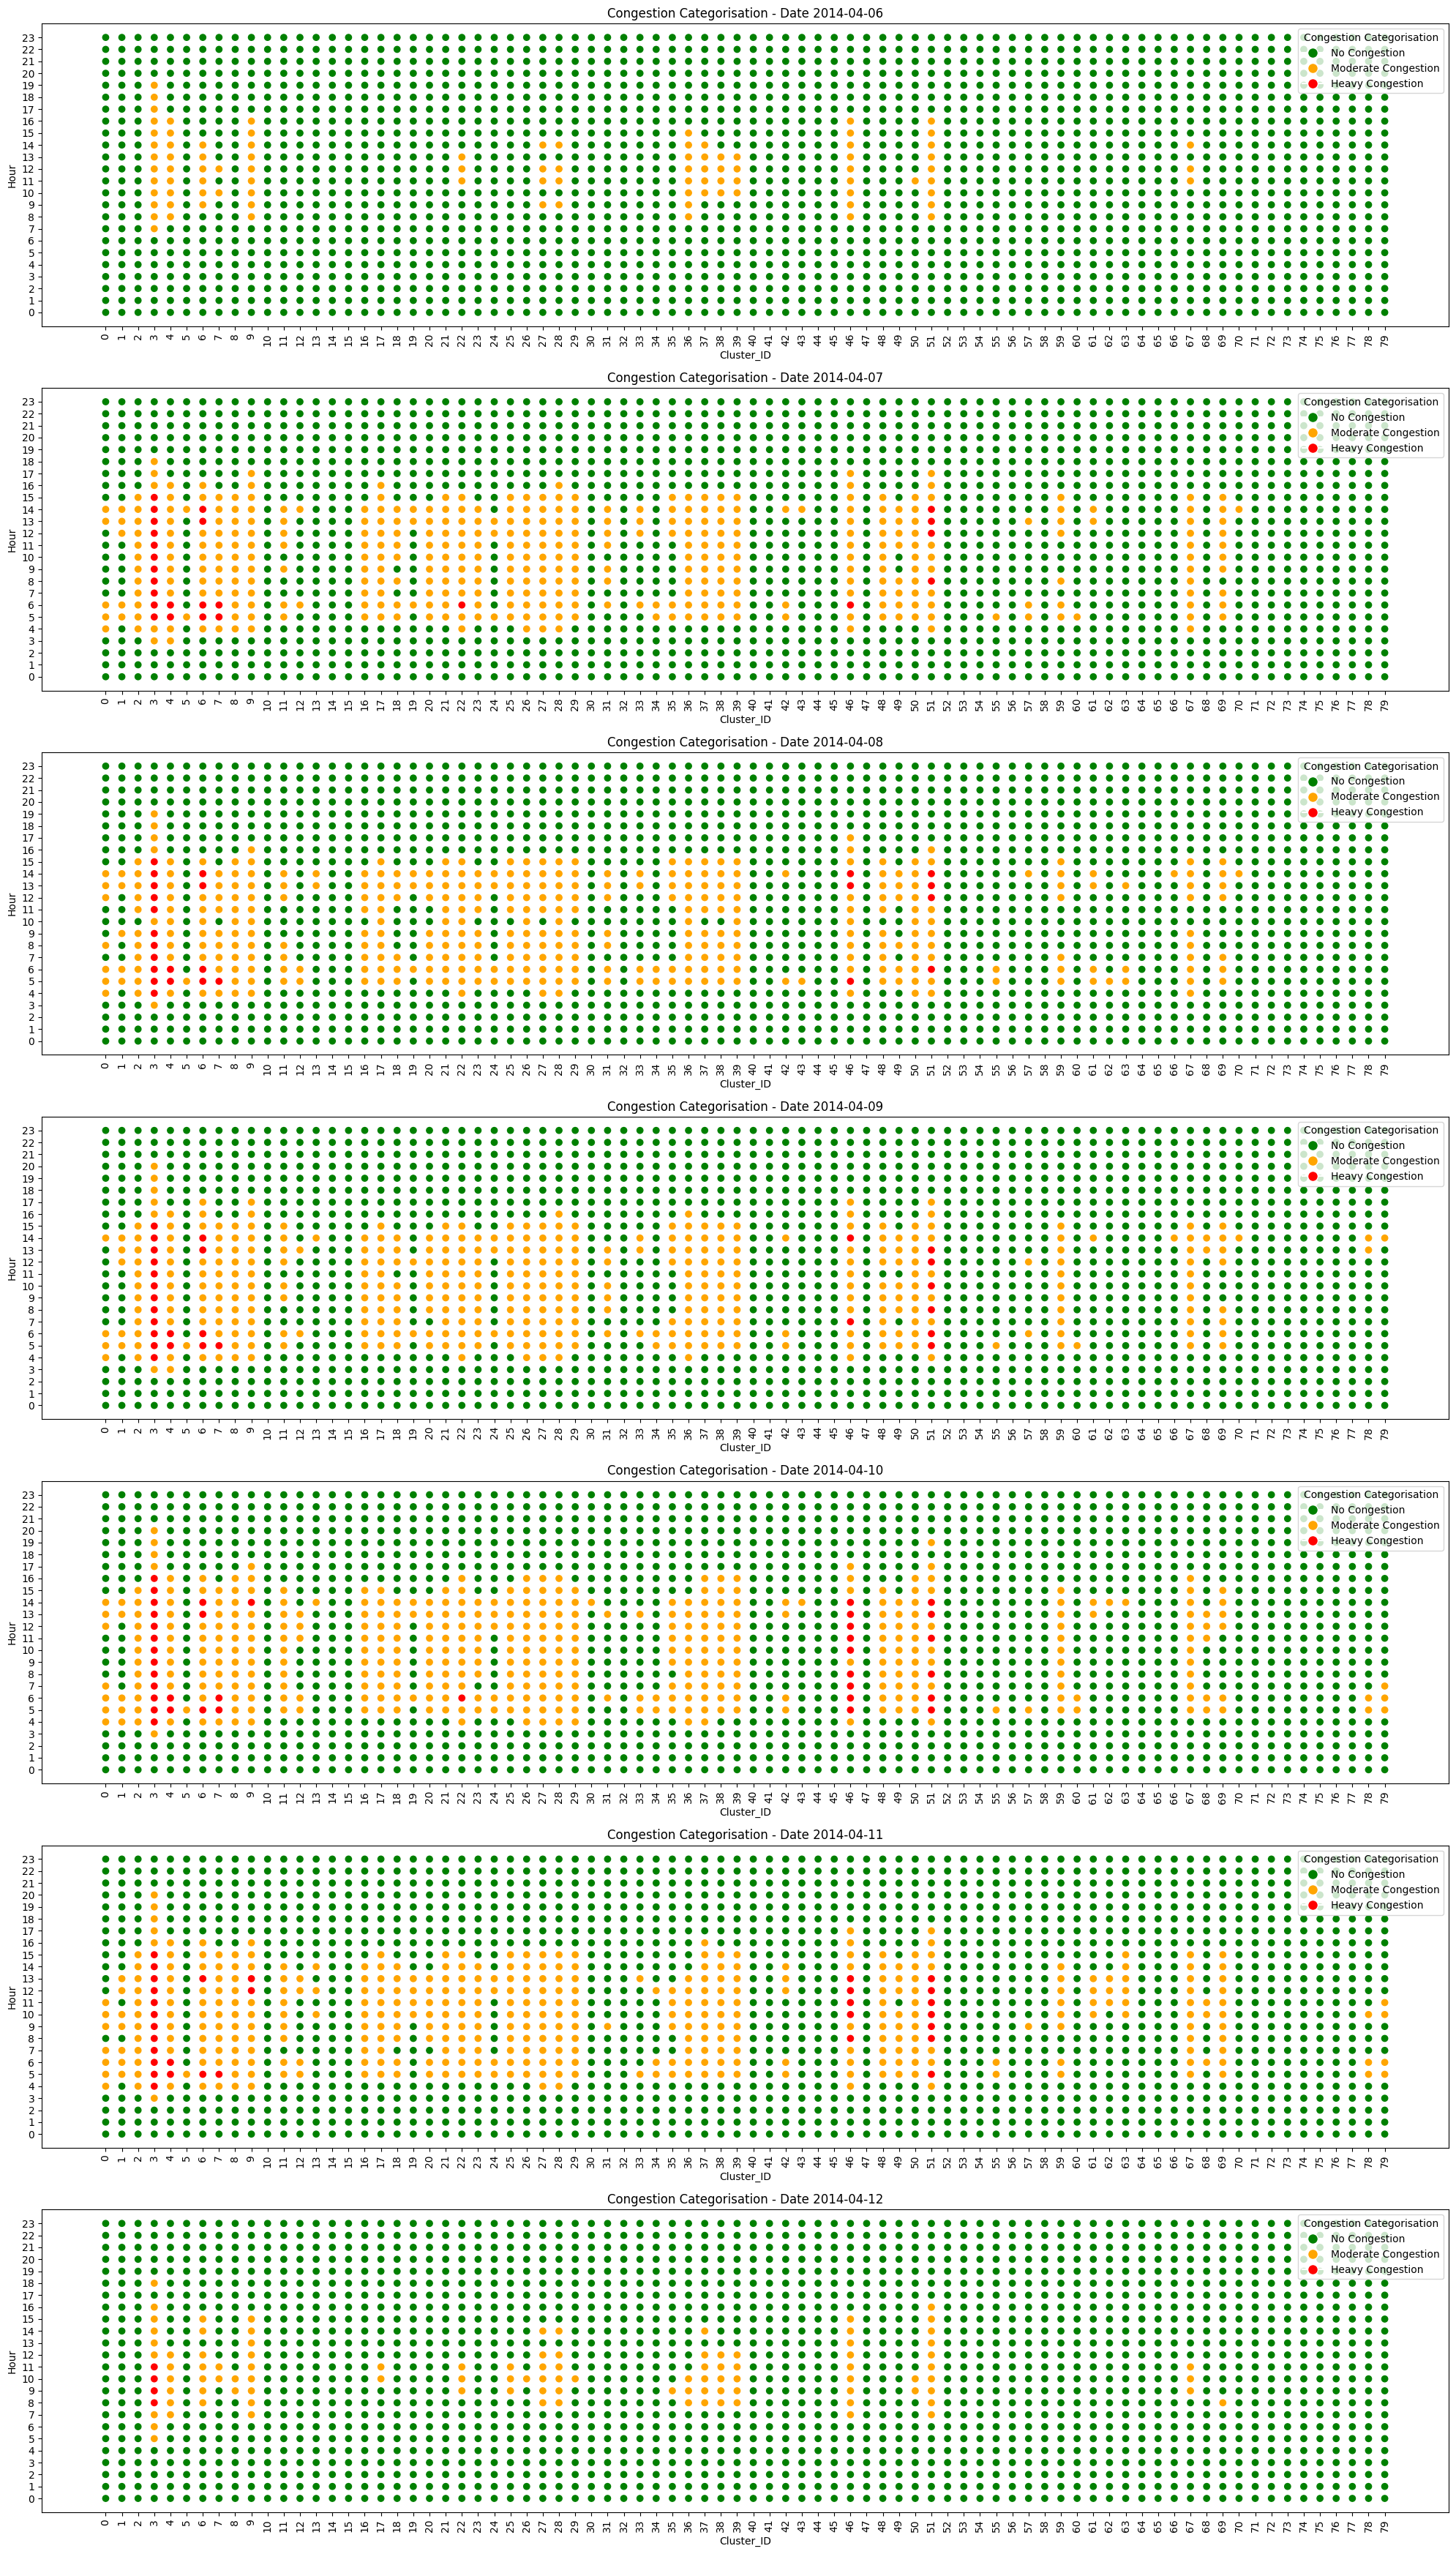

In [19]:
#---------------------------------#
# PLOTTING TYPES OF CONGESTION GRAPH
#---------------------------------#

# Define a custom color mapping for congested labels
colors = {'1': 'green', '2': 'orange', '3': 'red'}

# Define custom legend elements for congestion types
legend_elements = [mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='No Congestion'),
                   mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Moderate Congestion'),
                   mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Heavy Congestion')]

# Group the data by Date
grouped_date = result_df.groupby("Date")

# Create subplots with a 1x1 grid (one plot for each date)
fig, axes = plt.subplots(len(grouped_date), 1, figsize=(20, 5 * len(grouped_date)))

# Iterate through each group and create separate graphs
for idx, (name, group) in enumerate(grouped_date):
    ax = axes[idx]  # Access the specific subplot
    
    # Plot points for congested and not congested data in the current group
    scatter = ax.scatter(group['Cluster_ID'], group['Hour'], c=group['Congested_label'].map(colors))
    
    # Set labels
    ax.set_xlabel("Cluster_ID")
    ax.set_ylabel("Hour")
    ax.set_title(f"Congestion Categorisation - Date {name}")
    
    # Add a legend for each subplot
    ax.legend([scatter], ['Congested', 'Not Congested'], loc="upper right")

    # Set the x and y axis ticks to display all numbers
    ax.set_xticks(group['Cluster_ID'].unique())
    ax.set_yticks(group['Hour'].unique())
    ax.legend(handles=legend_elements, loc="upper right", title='Congestion Categorisation')
    ax.tick_params(axis='x', labelrotation=90)

# Adjust the layout and show the plots
plt.tight_layout()
plt.show()

In [20]:
#---------------------------------#
# FUNCTION FOR IDENTIFY COLOR OF THE CONGESTION TYPE FOR CREATING MAP (DATE = 2014-04-07, HOUR = 11AM)
#---------------------------------#

filtered_df = result_df[(result_df['Date'] == '2014-04-07') & (result_df['Hour'] == 11)]

def get_congested_color(report_id):
    for cluster_id, report_ids in zip(clustered_reports['Cluster_ID'], clustered_reports['REPORT_ID']):
        if report_id in report_ids:
            congested_label = filtered_df[filtered_df['Cluster_ID'] == cluster_id]['Congested_label'].values[0]
            color = colors.get(congested_label)
            return color, cluster_id

In [21]:
#---------------------------------#
# PLOTTING CONGESTION MAP
#---------------------------------#

import folium
import pandas as pd

# Sample data (replace with your actual dataset)
columns_to_copy = ['POINT_1_LAT', 'POINT_1_LNG', 'POINT_2_LAT', 'POINT_2_LNG', 'REPORT_ID']

# Create a new DataFrame with the selected columns
# Replace 'traffic_metadata' with your actual DataFrame
data = traffic_metadata.loc[:, columns_to_copy]

# Create a folium map centered at a location (you can calculate a central location based on your data)
center_lat = data['POINT_1_LAT'].mean()
center_lng = data['POINT_1_LNG'].mean()
m = folium.Map(location=[center_lat, center_lng], zoom_start=10)

# Define a style to format the REPORT_ID text
marker_style = "<div style='font-size: 10px; color: white; font-family: cursive; background: black; width: max-content; padding: 5px;'>{0}</div>"

# Create a dictionary to store locations by cluster
cluster_locations = {}

# Iterate through the DataFrame and add colored polylines between 'POINT_1' and 'POINT_2'
for index, row in data.iterrows():
    start_location = [row['POINT_1_LAT'], row['POINT_1_LNG']]
    end_location = [row['POINT_2_LAT'], row['POINT_2_LNG']]
    cluster_id = 0  # Replace with your cluster function

    # Use a different color for each report_id
    temp = get_congested_color(int(row['REPORT_ID']))
    
    # This condition is to make map more readable (exclusing clusters which are noise and on top of that clusters which has cluster id 0 (not required just for visual representation))
    if temp is not None and temp[1] != -1 and temp[1] != 0:
        color = temp[0]
        cluster_id = temp[1]
        display_value = f"RID - {row['REPORT_ID']} | CID - {cluster_id}"
    else:
        color = "transparent"
        cluster_id = 0
        display_value = f"RID - NONE | CID - NONE"

    # Add a popup at the midpoint with REPORT_ID, using the defined style
    folium.Marker(location=start_location, icon=folium.DivIcon(html=marker_style.format(display_value))).add_to(m)
    folium.CircleMarker(location=start_location, radius=20, color=color, fill=True).add_to(m)
    
    # Check if this location belongs to a cluster
    if cluster_id is not None:
        if cluster_id in cluster_locations:
            # Draw a line between locations in the same cluster
            for loc in cluster_locations[cluster_id]:
                folium.PolyLine([start_location, loc], color=color).add_to(m)
            cluster_locations[cluster_id].append(start_location)
        else:
            cluster_locations[cluster_id] = [start_location]

# Save the map to an HTML file
m.save('my_map_with_clusters.html')